# STEP 1. Gathering Data

** (i) Importing Libraries**

In [324]:
!pip install arxiv
import pandas as pd
import numpy as np
import collections
import operator
import json
import pickle
import arxiv
import time
import seaborn as sns
import matplotlib.pyplot as pl
import plotly.plotly as py
import networkx as nx
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json


Using TensorFlow backend.


** (ii) Loading the data**

In [0]:
FILE_PATH = 'dblp-ref-3.json'

# Specifying most optimal datatypes for corresponding columns
datatypes = {
             'n_citation':'uint32',
             'year':'uint16',
            }

data_df = pd.read_json(FILE_PATH, lines=True, dtype = datatypes)

# Removing unnecessary columns
data_df = data_df.drop(columns=['abstract'])

In [239]:
data_df.head()

authors  \
0  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1    [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2               [Xiaodong Ai, Keyou You, Shiji Song]   
3                  [Francine Berman, Vinton G. Cerf]   
4  [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  year  
0      high performance computing and communications  2016  
1  international conference on conceptual structures  2016  
2  international conference on control, automatio...  2016  
3                          Communications of The ACM  2017  
4                 Journal of Computational Chemistry  2017

# STEP 2. Data Preprocessing

** (i) Filling in the missing values**

In [0]:
# Filling in NaN references with empty [] - 
# assumption being made that those do not refer any other paper
for row in data_df.loc[data_df.references.isnull(), 'references'].index:
    data_df.at[row, 'references'] = []
    
# Filling in missing conferences with most frequent conference of the first author - 
# assumption being made that first author is the most prominent author
author_conf = collections.defaultdict(list)

def list_of_authors_conf(row):
    global author_conf
    for author in row.authors:
        if row.venue != "":
            author_conf[author].append(row.venue)
        
data_df.apply(list_of_authors_conf, axis = 1)
for author in author_conf.keys():
    counter = collections.Counter(author_conf[author])
    most_frequent = counter.most_common()
    author_conf[author] = [most_frequent[0][0]]

In [0]:
def impute_missing_conf(row):
    global author_conf
    
    if row.venue == "":
        for x in row.authors:
            if len(author_conf[x]) > 0:
                return author_conf[x][0]
        return "others"
    else:
        return row.venue
    
data_df['venue'] = data_df.apply(impute_missing_conf, axis = 1)

In [242]:
data_df.head()

authors  \
0  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1    [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2               [Xiaodong Ai, Keyou You, Shiji Song]   
3                  [Francine Berman, Vinton G. Cerf]   
4  [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  year  
0      high performance computing and communications  2016  
1  international conference on conceptual structures  2016  
2  international conference on control, automatio...  2016  
3                          Communications of The ACM  2017  
4                 Journal of Computational Chemistry  2017

In [243]:
len(data_df[data_df.venue == ""])

0

In [244]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79007 entries, 0 to 79006
Data columns (total 7 columns):
authors       79007 non-null object
id            79007 non-null object
n_citation    79007 non-null uint32
references    79007 non-null object
title         79007 non-null object
venue         79007 non-null object
year          79007 non-null uint16
dtypes: object(5), uint16(1), uint32(1)
memory usage: 6.6+ MB


** (ii) Removing outliers**

In [0]:
# Keeping the papers having less than or equal to 15 authors
data_df = data_df[data_df.apply(lambda x: len(x['authors']) <= 15, axis = 1)]

In [246]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78859 entries, 0 to 79006
Data columns (total 7 columns):
authors       78859 non-null object
id            78859 non-null object
n_citation    78859 non-null uint32
references    78859 non-null object
title         78859 non-null object
venue         78859 non-null object
year          78859 non-null uint16
dtypes: object(5), uint16(1), uint32(1)
memory usage: 4.1+ MB


** (iii) Feature Extraction - Adding extracted categories and sub-categories**

In [0]:
# Adding the categories extracted for each paper from ArXiv API
df_categories = pd.read_csv('categories.csv')

In [248]:
# Removing duplicate entries from categories by title
df_categories = df_categories.sort_values(by='title').drop_duplicates('title')  
print(any(df_categories['title'].duplicated())) 
df_categories.info()

False
<class 'pandas.core.frame.DataFrame'>
Int64Index: 78984 entries, 57336 to 5126
Data columns (total 3 columns):
title          78984 non-null object
subcategory    78984 non-null object
category       78984 non-null object
dtypes: object(3)
memory usage: 2.4+ MB


In [249]:
data_df = pd.merge(data_df, df_categories,  how='left', left_on=['title'], right_on = ['title'])
data_df

authors  \
0      [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1        [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2                   [Xiaodong Ai, Keyou You, Shiji Song]   
3                      [Francine Berman, Vinton G. Cerf]   
4      [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   
5                 [Nuno Moniz, Luís Torgo, João Vinagre]   
6       [Vincent Buntinx, Cyril Bornet, Frédéric Kaplan]   
7                    [Atsushi Takayasu, Noboru Kunihiro]   
8      [Ankit Verma, Monika Sharma, Ramya Hebbalagupp...   
9                [Elaine Vedrasco, Chidchanok Lursinsap]   
10     [Long Qian, Alexander Winkler, Bernhard Fuerst...   
11     [Aijie Zou, Yuxuan Fang, Fengyu Guan, Yijin Zh...   
12     [Ioanna Ersi Pervolaraki, Emmanouel Garoufallo...   
13        [Kazuhiro Homma, Kiyoyuki Chinzei, Koji Hyodo]   
14                         [P. Karpiński, John McDonald]   
15     [Jan Křetínský, Tobias Meggendorfer, Clara Wal...   
16               [Nicola Maiellaro, Antonietta Varasano]   
17     [Marta Nuñez-Garcia, David Andreu, Marta Male,...   
18     [Maria Dimou, Theofilos Kossyvakis, Costas Cha...   
19          [Ekta Gandotra, Divya Bansal, Sanjeev Sofat]   
20     [Erwan Bousse, Manuel Wimmer, Wieland Schwinge...   
21                       [Zhipeng Huang, Nikos Mamoulis]   
22              [Giovani Guizzo, Silvia Regina Vergilio]   
23     [Dejana Golenko, Kornelija Petr Balog, Ljiljan...   
24         [Lydia Y. Chen, Robert Birke, Evgenia Smirni]   
25     [Leonardo Maccari, Quynh Nguyen, Renato Lo Cigno]   
26                                   [Paul Raff, Ze Jin]   
27     [Gregory W. Hislop, Massood Towhidnejad, Willi...   
28                       [Xuan Zhou, Feng He, Tong Wang]   
29     [Chung Chan, Manuj Mukherjee, Navin Kashyap, Q...   
...                                                  ...   
78829                               [Valentina Salapura]   
78830               [Ekaterina Bazhenova, Mathias Weske]   
78831  [Roman Senkerik, Zuzana Kominkova Oplatkova, I...   
78832                                   [Carlo A. Furia]   
78833  [Yoshikazu Uchiyama, Kiyomu Ishikawa, Hidehiko...   
78834  [Richard W. Conway, Charles G. Moore, Steven L...   
78835                          [Enrique Areyan Viqueira]   
78836  [Gregory P. Finley, Serguei V. S. Pakhomov, Re...   
78837  [Lorenzo Bottarelli, Jason L. Blum, Manuele Bi...   
78838   [Stéphane Lengrand, Roy Dyckhoff, James McKinna]   
78839     [Raoua Abdelkhalek, I. Boukhris, Zied Elouedi]   
78840                   [Henry A. Gabb, Catherine Blake]   
78841                                    [Erwin Reifler]   
78842  [Karim Tabia, Amélie Levray, Maroua Haddad, Ph...   
78843                     [James Jin Kang, Henry Larkin]   
78844         [Wolfgang Hürst, Tobias Lauer, Georg Götz]   
78845  [Saptarashmi Bandyopadhyay, Soumyadeep Basu, R...   
78846          [Shreyas Sekar, Sujoy Sikdar, Lirong Xia]   
78847  [Debarun Kar, Benjamin J. Ford, Shahrzad Ghola...   
78848  [Ram Charan Baishya, Nozrul Hoque, Dhruba K. B...   
78849           [Shufeng Kong, Jae Hee Lee, Sanjiang Li]   
78850  [Saeede Eftekhari, Niam Yaraghi, Ram D. Gopal,...   
78851      [Paul W. Goldberg, Christos H. Papadimitriou]   
78852  [Stefan Niemczyk, Stephan Opfer, Nugroho Fredi...   
78853     [Samantha Dick, Yvonne O'Connor, Ciara Heavin]   
78854  [Hassan Charaf, Peter Ekler, Tamás Mészáros, I...   
78855  [Saul Blecker, Stuart D. Katz, Leora I. Horwit...   
78856  [Dzmitry Bahdanau, Tom Bosc, Stanisław Jastrzę...   
78857  [Kirsti Askedal, Leif Skiftenes Flak, Eirik Ab...   
78858                                 [Ilona Kopocińska]   

                                         id  n_citation  \
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
3      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4      013ea675-bb58-42f8-a423-f5

In [250]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78859 entries, 0 to 78858
Data columns (total 9 columns):
authors        78859 non-null object
id             78859 non-null object
n_citation     78859 non-null uint32
references     78859 non-null object
title          78859 non-null object
venue          78859 non-null object
year           78859 non-null uint16
subcategory    78859 non-null object
category       78859 non-null object
dtypes: object(7), uint16(1), uint32(1)
memory usage: 5.3+ MB


** (iv) Adding extracted popularity from Google Trends and Ngrams API**

In [0]:
# Popularity of each category from 1955 - 2003
df_categories_popularity_ngrams = pd.read_csv('Category_pop_ngrams.csv')
# Popularity of each category from 2004 - 2018
df_categories_popularity_trends = pd.read_csv('Category_pop_trends.csv')
# Popularity of each sub-category from 1955 - 2003
df_subcategories_popularity_ngrams = pd.read_csv('Subcategory_pop_ngrams.csv')
# Popularity of each sub-category from 2004 - 2018
df_subcategories_popularity_trends = pd.read_csv('Subcategory_pop_trends.csv')

In [0]:
# Filtering and Normalizing the popularities to the range 0-1

df_categories_popularity_ngrams = df_categories_popularity_ngrams[df_categories_popularity_ngrams.year < 2004]
df_categories_popularity_ngrams['Ngrams Result']=((df_categories_popularity_ngrams['Ngrams Result']-df_categories_popularity_ngrams['Ngrams Result'].mean())/(df_categories_popularity_ngrams['Ngrams Result'].std()))
df_categories_popularity_ngrams = df_categories_popularity_ngrams.rename(index=str, columns={'Ngrams Result': "cat_pop", 'Category': "category"})

df_categories_popularity_trends = df_categories_popularity_trends[df_categories_popularity_trends.year >= 2004]
df_categories_popularity_trends['Google Trends Score']=(df_categories_popularity_trends['Google Trends Score']-df_categories_popularity_trends['Google Trends Score'].min())/(df_categories_popularity_trends['Google Trends Score'].max()-df_categories_popularity_trends['Google Trends Score'].min())
df_categories_popularity_trends = df_categories_popularity_trends.rename(index=str, columns={'Google Trends Score': "cat_pop", 'Category': "category"})

df_subcategories_popularity_ngrams = df_subcategories_popularity_ngrams[df_subcategories_popularity_ngrams.year < 2004]
df_subcategories_popularity_ngrams['Ngrams Result']=((df_subcategories_popularity_ngrams['Ngrams Result']-df_subcategories_popularity_ngrams['Ngrams Result'].mean())/(df_subcategories_popularity_ngrams['Ngrams Result'].std()))
df_subcategories_popularity_ngrams = df_subcategories_popularity_ngrams.rename(index=str, columns={'Ngrams Result': "subcat_pop", 'SubCategory': "subcategory"})

df_subcategories_popularity_trends = df_subcategories_popularity_trends[df_subcategories_popularity_trends.year >= 2004]
df_subcategories_popularity_trends['Google Trends Score']=(df_subcategories_popularity_trends['Google Trends Score']-df_subcategories_popularity_trends['Google Trends Score'].min())/(df_subcategories_popularity_trends['Google Trends Score'].max()-df_subcategories_popularity_trends['Google Trends Score'].min())
df_subcategories_popularity_trends = df_subcategories_popularity_trends.rename(index=str, columns={'Google Trends Score': "subcat_pop", 'Category': "subcategory"})

In [253]:
df_cat = pd.concat([df_categories_popularity_ngrams, df_categories_popularity_trends])
df_cat['cat_pop']=(df_cat['cat_pop']-df_cat['cat_pop'].min())/(df_cat['cat_pop'].max()-df_cat['cat_pop'].min())
df_subcat = pd.concat([df_subcategories_popularity_ngrams, df_subcategories_popularity_trends])
df_subcat['subcat_pop']=(df_subcat['subcat_pop']-df_subcat['subcat_pop'].min())/(df_subcat['subcat_pop'].max()-df_subcat['subcat_pop'].min())

data_df = pd.merge(data_df, df_cat,  how='left', left_on=['category' , 'year'], right_on = ['category' , 'year'])
data_df = pd.merge(data_df, df_subcat,  how='left', left_on=['subcategory' , 'year'], right_on = ['subcategory' , 'year'])
data_df.head()

authors  \
0  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1    [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2               [Xiaodong Ai, Keyou You, Shiji Song]   
3                  [Francine Berman, Vinton G. Cerf]   
4  [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  year  \
0      high performance computing and communications  2016   
1  international conference on conceptual structures  2016   
2  international conference on control, automatio...  2016   
3                          Communications of The ACM  2017   
4                 Journal of Computational Chemistry  2017   

                               subcategory              category   cat_pop  \
0                    Information Retrieval      Computer Science  0.221553   
1                Cryptography and Security      Computer Science  0.221553   
2  Computer Vision and Pattern Recognition      Computer Science  0.221553   
3                    Computers and Society      Computer Science  0.234329   
4                             Biomolecules  Quantitative Biology  0.109077   

   subcat_pop  
0    0.033280  
1    0.066312  
2    0.051033  
3    0.032731  
4    0.057133

In [254]:
data_df['cat_pop'].fillna(0, inplace=True)
data_df['subcat_pop'].fillna(0, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78859 entries, 0 to 78858
Data columns (total 11 columns):
authors        78859 non-null object
id             78859 non-null object
n_citation     78859 non-null uint32
references     78859 non-null object
title          78859 non-null object
venue          78859 non-null object
year           78859 non-null uint16
subcategory    78859 non-null object
category       78859 non-null object
cat_pop        78859 non-null float64
subcat_pop     78859 non-null float64
dtypes: float64(2), object(7), uint16(1), uint32(1)
memory usage: 6.5+ MB


In [0]:
# Defining a combined popularity score for category and subcategory
def get_popularity(row):
    return 0.20 * row.cat_pop +  0.80 * row.subcat_pop
    
data_df['popularity'] = data_df.apply(get_popularity, axis = 1)

In [256]:
data_df.head()

authors  \
0  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1    [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2               [Xiaodong Ai, Keyou You, Shiji Song]   
3                  [Francine Berman, Vinton G. Cerf]   
4  [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  year  \
0      high performance computing and communications  2016   
1  international conference on conceptual structures  2016   
2  international conference on control, automatio...  2016   
3                          Communications of The ACM  2017   
4                 Journal of Computational Chemistry  2017   

                               subcategory              category   cat_pop  \
0                    Information Retrieval      Computer Science  0.221553   
1                Cryptography and Security      Computer Science  0.221553   
2  Computer Vision and Pattern Recognition      Computer Science  0.221553   
3                    Computers and Society      Computer Science  0.234329   
4                             Biomolecules  Quantitative Biology  0.109077   

   subcat_pop  popularity  
0    0.033280    0.070935  
1    0.066312    0.097360  
2    0.051033    0.085137  
3    0.032731    0.073050  
4    0.057133    0.067522

** (v) Saving the data into pickle for faster load**

In [0]:
# # Pickling the edited dataframe for faster loads
data_df.to_pickle('transformed-dblp-ref-3.pkl')

In [0]:
# # Reading the pickled file
# data_df = pd.read_pickle("/Users/Shubham/Downloads/dblp-ref/transformed-dblp-ref-3.pkl")

# STEP 3. Devising Reach Function and Calculating Paper's Score

** (i) Making the citation network graph (Task 2)**

In [259]:
# papers_outlinks_graph is our Citation Network graph where each edge (outlink)
# represents which paper is citing which paper
papers_outlinks_graph = collections.defaultdict(list)
# Inlink represents which paper is being cited by which paper
papers_inlinks_graph = collections.defaultdict(list)
# Dictionary with paper_id as key and year of publication as value
papers_year = collections.defaultdict(list)
# Dictionary with paper_id as key and conference of publication as value
papers_conf = collections.defaultdict(list)
# Dictionary with conference as key and dictionary of (year:count of paper published) as value
conf_paper_year = {}
# Dictionary with paper_id as key and n_citations as value
papers_cit = collections.defaultdict(int)

# Dictionary with paper_id as key and category as value
paper_category = collections.defaultdict(str)
# Dictionary with paper_id as key and subcategory as value
paper_subcategory = collections.defaultdict(str)
# Dictionary with category as key and number of papers as value
category_numberPaper = collections.defaultdict(int)
# Dictionary with category as key and set of authors as value
category_numberAuthor = collections.defaultdict(set)
# Dictionary with subcategory as key and number of papers as value
subcategory_numberPaper = collections.defaultdict(int)
# Dictionary with subcategory as key and set of authors as value
subcategory_numberAuthor = collections.defaultdict(set)
# Dictionary with category as key and dictionary of year->popularity as value
popularity_cat_year = {}
# Dictionary with subcategory as key and dictionary of year->popularity as value
popularity_subcat_year = {}
# Dictionary with paper_id as key and popularity as value
popuplarity_paper = collections.defaultdict(int)

def create_citation_network_graph(row):
    global papers_outlinks_graph
    global papers_inlinks_graph
    global papers_year
    global papers_conf
    global conf_paper_year
    global papers_cit
    global paper_category
    global paper_subcategory
    global category_numberPaper
    global category_numberAuthor
    global subcategory_numberPaper
    global subcategory_numberAuthor
    global popularity_cat_year
    global popularity_subcat_year
    global popuplarity_paper
    

    papers_outlinks_graph[row.id] += row.references
    
    for x in row.references:
        papers_inlinks_graph[x].append(row.id)
    if row.id not in papers_inlinks_graph.keys():
        papers_inlinks_graph[row.id] = []
        
    papers_year[row.id] = row.year
    papers_conf[row.id] = row.venue
    
    if row.venue not in conf_paper_year.keys():
        conf_paper_year[row.venue] = {}
    if row.year not in conf_paper_year[row.venue].keys():
        conf_paper_year[row.venue][row.year] = 0
        
    conf_paper_year[row.venue][row.year] += 1
    papers_cit[row.id] = row.n_citation
    
    paper_category[row.id] = row.category
    paper_subcategory[row.id] = row.subcategory
    
    category_numberPaper[row.category] += 1
    for x in row.authors:
        category_numberAuthor[row.category].add(x)
        
    subcategory_numberPaper[row.subcategory] += 1
    for x in row.authors:
        subcategory_numberAuthor[row.subcategory].add(x)
        
    if row.category not in popularity_cat_year.keys():
        popularity_cat_year[row.category] = {}
        popularity_cat_year[row.category][row.year] = row.cat_pop
    else:
        if row.year not in popularity_cat_year[row.category].keys():
            popularity_cat_year[row.category][row.year] = row.cat_pop
            
    if row.subcategory not in popularity_subcat_year.keys():
        popularity_subcat_year[row.subcategory] = {}
        popularity_subcat_year[row.subcategory][row.year] = row.subcat_pop
    else:
        if row.year not in popularity_subcat_year[row.subcategory].keys():
            popularity_subcat_year[row.subcategory][row.year] = row.subcat_pop
            
    popuplarity_paper[row.id] = row.popularity
            

data_df.apply(create_citation_network_graph, axis = 1)



# print("Outlinks")
# print(papers_outlinks_graph)
# print("Inlinks")
# print(papers_inlinks_graph)
# print("papers_year")
# print(papers_year)
# print("papers_conf")
# print(papers_conf)
# print("conf_paper_year")
# print(conf_paper_year)
# print("papers_cit")
# print(papers_cit)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
78829    None
78830    None
78831    None
78832    None
78833    None
78834    None
78835    None
78836    None
78837    None
78838    None
78839    None
78840    None
78841    None
78842    None
78843    None
78844    None
78845    None
78846    None
78847    None
78848    None
78849    None
78850    None
78851    None
78852    None
78853    None
78854    None
78855    None
78856    None
78857    None
78858    None
Length: 78859, dtype: object

In [0]:
G = nx.Graph()

c = 0
num_nodes = 100
for node, edges in papers_outlinks_graph.items():
    if c > num_nodes:
        break
    for edge in edges:
        G.add_edge(node, edge)
    c += 1

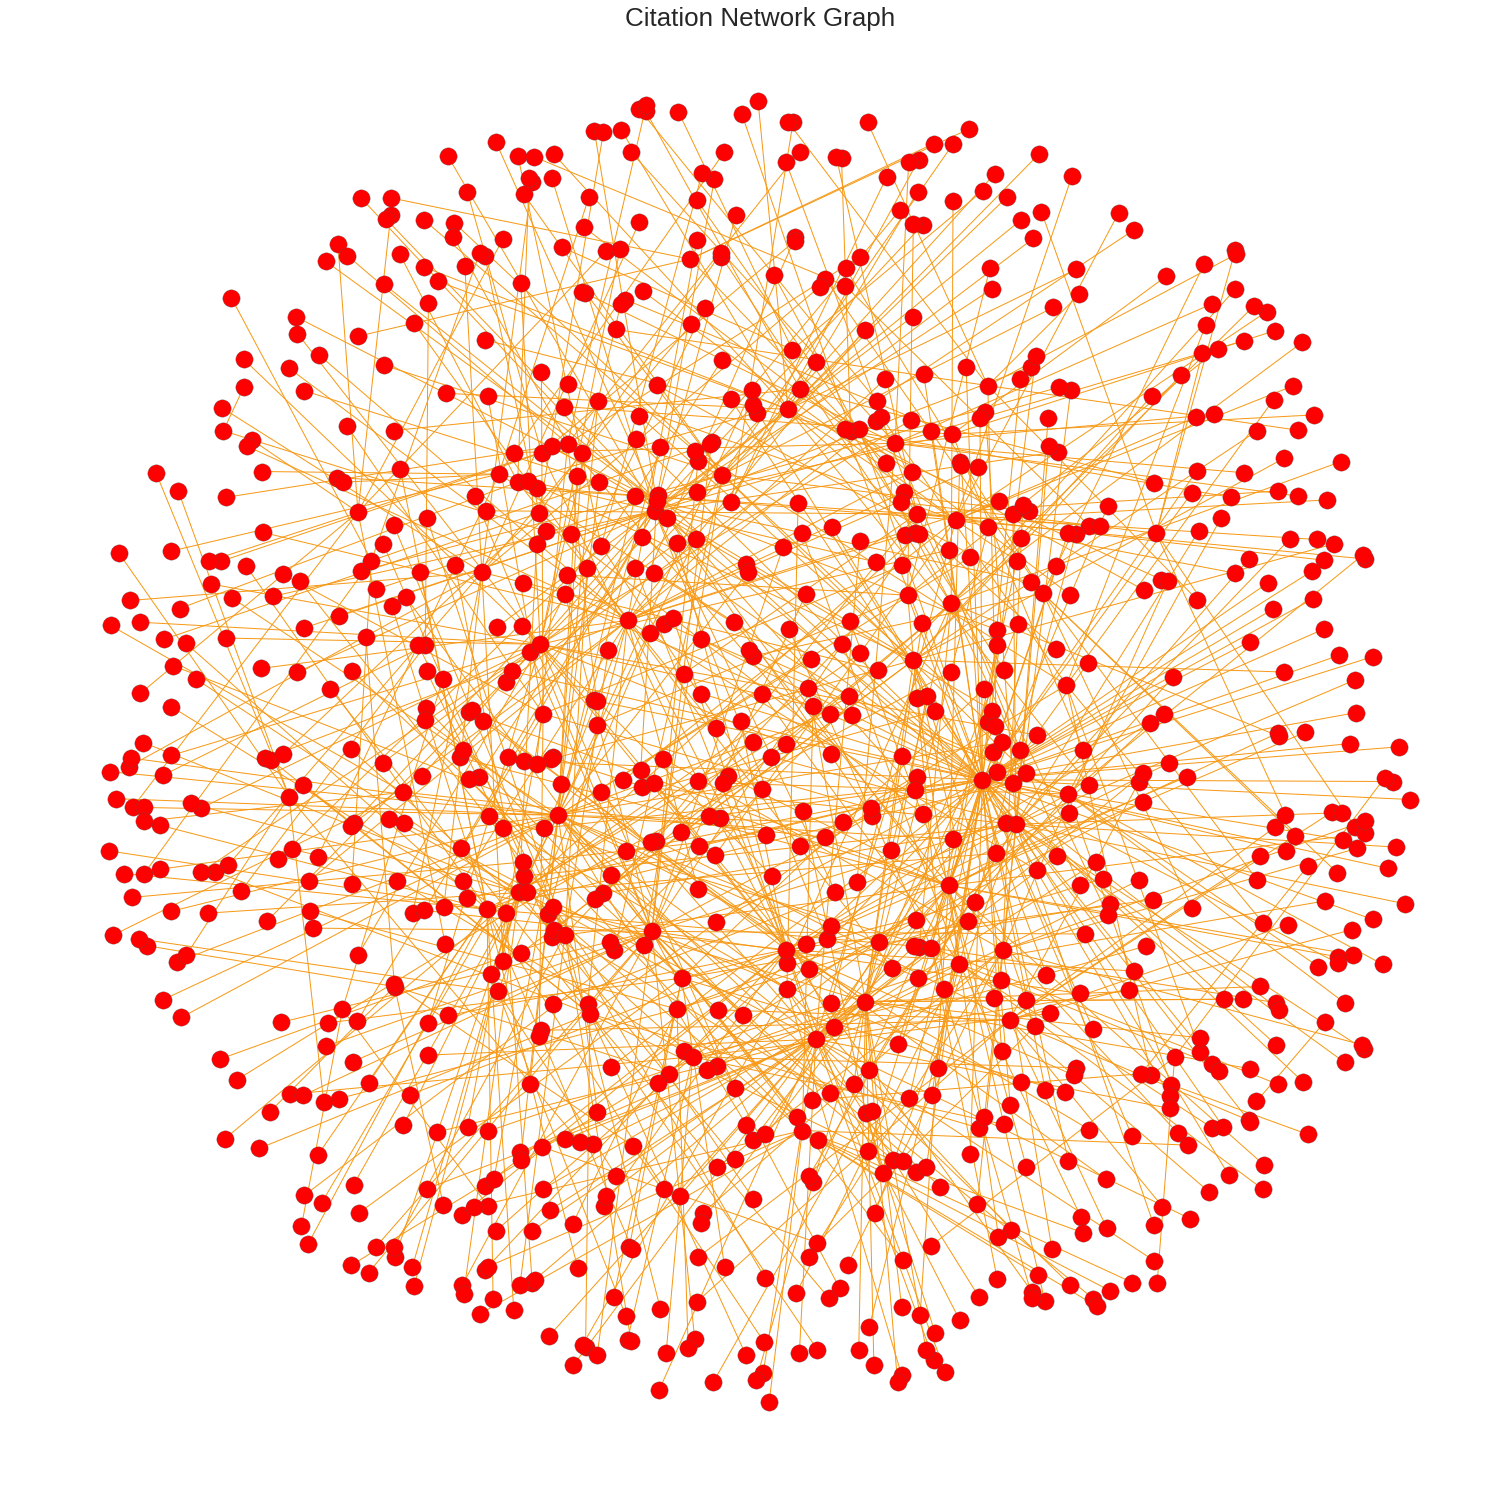

In [261]:
pl.figure(figsize=(20,20))
color_map = {1:'#f09494', 2:'#eebcbc', 3:'#72bbd0', 4:'#91f0a1', 5:'#629fff', 6:'#bcc2f2',  
             7:'#eebcbc', 8:'#f1f0c0', 9:'#d2ffe7', 10:'#caf3a6', 11:'#ffdf55', 12:'#ef77aa', 
             13:'#d6dcff', 14:'#d2f5f0'} 
options = {
    'edge_color': '#f79916',
    'width': 1,
    'with_labels': False,
    'font_weight': 'regular',
}
# colors = [color_map[G.node[node]['group']] for node in G]
# sizes = [G.node[node]['nodesize']*10 for node in G]

"""
Using the spring layout : 
- k controls the distance between the nodes and varies between 0 and 1
- iterations is the number of times simulated annealing is run
default k=0.1 and iterations=50
"""
nx.draw(G, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = pl.gca()
ax.collections[0].set_edgecolor("#555555") 
pl.title('Citation Network Graph', fontsize=26)
pl.show()

** (ii) Reach function to calculate paper's degree of influence **

In [0]:
# The basic idea here is that the more is the reach of a paper, the more will be its quality and thus the more score.
# the depth 80000 has been taken in consideration that no paper can be cited by more than 80000 papers which is the
# total number of papers in this dataset

In [263]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78859 entries, 0 to 78858
Data columns (total 12 columns):
authors        78859 non-null object
id             78859 non-null object
n_citation     78859 non-null uint32
references     78859 non-null object
title          78859 non-null object
venue          78859 non-null object
year           78859 non-null uint16
subcategory    78859 non-null object
category       78859 non-null object
cat_pop        78859 non-null float64
subcat_pop     78859 non-null float64
popularity     78859 non-null float64
dtypes: float64(3), object(7), uint16(1), uint32(1)
memory usage: 9.6+ MB


** (a) Time dependent version (Task 2)**

In [264]:
# Devising a reach function to calculate each paper's degree of influence
papers_rank = collections.defaultdict(list)
damping_factor = 0.85

start = time.time()

def reach():
    global papers_rank
    
    updated_papers_rank = collections.defaultdict(list)

    for paper in papers_outlinks_graph.keys():
        papers_rank[paper] = 1.0

    depth = 1

    while depth <= 1000:
        flag  = True
        
#         print("DEPTH: ")
#         print(depth)
        depth += 1

        for paper in papers_rank.keys():

            current_score = papers_rank[paper]
            if paper in papers_inlinks_graph.keys():
                inlinks_list = papers_inlinks_graph[paper]
                new_score = 0.0
                for inlink in inlinks_list:
                    if inlink in papers_rank.keys():
                        new_score += papers_rank[inlink]/(len(papers_outlinks_graph[inlink]) * (1 + popuplarity_paper[inlink])) 
                new_score = (1 - damping_factor) + damping_factor * new_score
                if current_score != new_score:
                    flag = False
                updated_papers_rank[paper] = new_score
                
        if flag == True:
            break
            
    papers_rank = updated_papers_rank

    
reach()

# Normalizing the range of the scores
max_score = max(papers_rank.values())
print(max_score)
for paper in papers_rank.keys():
    papers_rank[paper] /= max_score
    
print("normalised ranks")
print(papers_rank)

end = time.time()

print("performance: " + str(end - start))

time_dependent_papers_rank = papers_rank

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [265]:
print(set(papers_rank.values()))

{0.15781265230765484, 0.04753449711223112, 0.11616796120584638, 1.0, 0.1804789710799959, 0.07218245243546662, 0.2647914759030831, 0.049284087127372096, 0.05640626072200306, 0.06396387284030781, 0.06623822210843146, 0.04706750532284333, 0.07375967302816734, 0.04757338293324766, 0.057059242981974755, 0.05481856660656705, 0.048540155198786315, 0.05854524501009097, 0.05185018820014878, 0.09628928353652813, 0.15296817771021412, 0.09706399068789653, 0.049574416215936196, 0.2432872512515232, 0.05553335530676409, 0.05665934118441032, 0.08365768972353753, 0.11200649870965766, 0.08106695753738084, 0.06371681441650882, 0.06577129063258273, 0.048338603015118095, 0.06879230068945223, 0.04537364052837494, 0.055370567263942454, 0.05817297668007986, 0.049527549758241966, 0.09624909899088513, 0.048960072747434025, 0.055920945024855284, 0.06602014105672543, 0.05865121449843619, 0.23161061168753255, 0.06940818531050047, 0.20297870023725656, 0.08147856009472682, 0.04506451396398609, 0.04609910095537024, 0

** (b) Time independent version (Task 4)**

In [266]:
# To nullify the time-dependent effect of the older papers
# avg_year_cit_count represents the average number of citations to that paper
avg_year_cit_count = collections.defaultdict(float)

for paper in papers_year.keys():
#     print(papers_cit[paper])
#     print(papers_year[paper])
    avg_year_cit_count[paper] = papers_cit[paper]/(2018 - papers_year[paper] + 1)
    
print(set(avg_year_cit_count.values()))

{0.0, 0.25, 2.5, 3.7058823529411766, 4.166666666666667, 2.7777777777777777, 6.25, 5.555555555555555, 2.6315789473684212, 2.625, 5.0, 3.0, 12.5, 10.0, 14.279069767441861, 1.5625, 16.666666666666668, 17.272727272727273, 3.125, 18.0, 20.066666666666666, 21.9375, 4.0, 21.0, 4.25, 25.0, 4.75, 24.5, 20.692307692307693, 21.272727272727273, 5.75, 1.0, 0.5, 1.25, 0.75, 0.125, 7.0, 6.0, 0.0625, 7.25, 1.75, 8.375, 35.10526315789474, 7.5, 37.6, 8.9375, 9.5, 9.8125, 9.0, 9.25, 8.5, 10.5, 50.0, 52.07142857142857, 45.2, 10.125, 2.0, 11.0, 2.25, 2.875, 60.8125, 12.75, 2.125, 58.833333333333336, 12.0, 2.71875, 13.875, 13.625, 13.5, 13.0, 69.5, 68.55, 67.0, 14.0, 74.5, 74.92857142857143, 15.75, 15.0, 78.11111111111111, 78.0, 78.9, 3.75, 3.5, 3.1875, 3.875, 3.25, 0.21052631578947367, 16.6875, 82.875, 3.9375, 3.3125, 18.5, 1.7105263157894737, 17.0, 85.125, 18.625, 19.5, 19.25, 19.470588235294116, 19.0, 101.73333333333333, 4.5, 2.4545454545454546, 4.34375, 4.625, 4.9375, 22.0, 22.34375, 21.25, 23.3125, 24.

In [267]:
# Devising a reach function to calculate each paper's degree of influence
papers_rank = collections.defaultdict(list)
damping_factor = 0.85

start = time.time()

def reach():
    global papers_rank
    
    updated_papers_rank = collections.defaultdict(list)

    for paper in papers_outlinks_graph.keys():
        papers_rank[paper] = 1.0
        
    depth = 1

    while depth <= 1000:
        flag  = True
        
#         print("DEPTH: ")
#         print(depth)
        depth += 1

        for paper in papers_rank.keys():
            
            current_score = papers_rank[paper]
            if paper in papers_inlinks_graph.keys():
                inlinks_list = papers_inlinks_graph[paper]
                new_score = 0.0
                for inlink in inlinks_list:
                    if inlink in papers_rank.keys():
                        new_score += papers_rank[inlink] * avg_year_cit_count[inlink] /(len(papers_outlinks_graph[inlink]) * (1+popuplarity_paper[inlink]))
                new_score = (1 - damping_factor) + damping_factor * new_score 
                if current_score != new_score:
                    flag = False
                updated_papers_rank[paper] = new_score
                
        if flag == True:
            break
            
    papers_rank = updated_papers_rank

    
reach()

# Normalizing the range of the scores
max_score = max(papers_rank.values())
print(max_score)
for paper in papers_rank.keys():
    papers_rank[paper] /= max_score
    
print("normalised ranks")
print(papers_rank)

end = time.time()

print("performance: " + str(end - start))

time_independent_papers_rank = papers_rank

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [268]:
print(time_independent_papers_rank)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [269]:
print(set(papers_rank.values()))

{0.854441265245649, 0.08708842864250244, 0.10500809428068258, 1.0, 0.09996670093806515, 0.03345526935710641, 0.08334551788955391, 0.49922856646719715, 0.023578356203223908, 0.08274001903255712, 0.039600120701266846, 0.0537092714219174, 0.037319168999646386, 0.04011733985568711, 0.035898704165341584, 0.05967117343251616, 0.0366599444427287, 0.0712894255035952, 0.04070677913575606, 0.007698985297588851, 0.028625519497939695, 0.019415905387828246, 0.0390649845004978, 0.1756339915283718, 0.09828784656756542, 0.06009013074617101, 0.08748584392911511, 0.057835202068288225, 0.03707718844416434, 0.02393166606395707, 0.012220047144936125, 0.03854082961832811, 0.06641151399174744, 0.47961115797405546, 0.026294441953591152, 0.31724539754584674, 0.11522906800805105, 0.013672899444163337, 0.022323722955870432, 0.03687687534610624, 0.026761302708314956, 0.045874995096059364, 0.12454603819602202, 0.03304189345821225, 0.12458363179694316, 0.034420705739916256, 0.05066401355440061, 0.03664175541788158,

# STEP 4. Devising Conference's Score

In [0]:
conf_score = collections.defaultdict(float)
for paper in papers_rank.keys():
    conf_score[papers_conf[paper]] += papers_rank[paper]/conf_paper_year[papers_conf[paper]][papers_year[paper]]
# print("Conference scores")
# print(set(conf_score.values()))

# STEP 5. Devising Researcher's or Author's Score

In [0]:
# Calculating Position factor based on the position of the author in the list of authors
def position_factor(row):
    vals = []
    i = 1.0
    for x in row.authors:
        vals.append((x,i))
        if i >= 0.3:
            i -= 0.1
    return vals
    
data_df['authors_with_position'] = data_df.apply(position_factor, axis = 1)

In [0]:
# Adding conference score and paper score in the dataframe
def add_conf_score(row):
    global conf_score
    return conf_score[row.venue]

def add_paper_score(row):
    global papers_rank
    return papers_rank[row.id]

data_df["conference_score"] = data_df.apply(add_conf_score, axis = 1)
data_df["paper_score"] = data_df.apply(add_paper_score, axis = 1)

In [273]:
data_df.head()

authors  \
0  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...   
1    [Yufei Liang, Yan Zhang, Tao Dong, Shan-wei Lu]   
2               [Xiaodong Ai, Keyou You, Shiji Song]   
3                  [Francine Berman, Vinton G. Cerf]   
4  [Leon A. Sakkal, Kyle Z. Rajkowski, Roger S. A...   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  year  \
0      high performance computing and communications  2016   
1  international conference on conceptual structures  2016   
2  international conference on control, automatio...  2016   
3                          Communications of The ACM  2017   
4                 Journal of Computational Chemistry  2017   

                               subcategory              category   cat_pop  \
0                    Information Retrieval      Computer Science  0.221553   
1                Cryptography and Security      Computer Science  0.221553   
2  Computer Vision and Pattern Recognition      Computer Science  0.221553   
3                    Computers and Society      Computer Science  0.234329   
4                             Biomolecules  Quantitative Biology  0.109077   

   subcat_pop  popularity                              authors_with_position  \
0    0.033280    0.070935  [(Zheng Xu, 1.0), (Runbin Shi, 0.9), (Zhihao S...   
1    0.066312    0.097360  [(Yufei Liang, 1.0), (Yan Zhang, 0.9), (Tao Do...   
2    0.051033    0.085137  [(Xiaodong Ai, 1.0), (Keyou You, 0.9), (Shiji ...   
3    0.032731    0.073050    [(Francine Berman, 1.0), (Vinton G. Cerf, 0.9)]   
4    0.057133    0.067522  [(Leon A. Sakkal, 1.0), (Kyle Z. Rajkowski, 0....   

   conference_score  paper_score  
0           0.01935      0.00645  
1           0.04515      0.00645  
2           0.07524      0.00645  
3           0.12675      0.00645  
4           0.01935      0.00645

In [274]:
# Splitting all rows via their authors to calculate each author's score individually
authors_data = data_df[['authors_with_position', 'id', 'n_citation', 'references', 'title', 'venue', 'conference_score', 'paper_score', 'category', 'subcategory']]
authors_data.head()

authors_with_position  \
0  [(Zheng Xu, 1.0), (Runbin Shi, 0.9), (Zhihao S...   
1  [(Yufei Liang, 1.0), (Yan Zhang, 0.9), (Tao Do...   
2  [(Xiaodong Ai, 1.0), (Keyou You, 0.9), (Shiji ...   
3    [(Francine Berman, 1.0), (Vinton G. Cerf, 0.9)]   
4  [(Leon A. Sakkal, 1.0), (Kyle Z. Rajkowski, 0....   

                                     id  n_citation  \
0  001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1  002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2  00352759-f0a7-4678-82ae-fed68c700da6           0   
3  00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4  013ea675-bb58-42f8-a423-f5534546b2b1          50   

                                          references  \
0  [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1                                                 []   
2  [1862a08a-08c6-4ab1-a214-8932bbd0d2d9, 7bcea2f...   
3                                                 []   
4  [4f4f200c-0764-4fef-9718-b8bccf303dba, aa699fb...   

                                               title  \
0  A Heterogeneous System for Real-Time Detection...   
1      A novel conformal jigsaw EBG structure design   
2  A source-seeking strategy for an autonomous un...   
3  Social and ethical behavior in the internet of...   
4  Prediction of consensus binding mode geometrie...   

                                               venue  conference_score  \
0      high performance computing and communications           0.01935   
1  international conference on conceptual structures           0.04515   
2  international conference on control, automatio...           0.07524   
3                          Communications of The ACM           0.12675   
4                 Journal of Computational Chemistry           0.01935   

   paper_score              category                              subcategory  
0      0.00645      Computer Science                    Information Retrieval  
1      0.00645      Computer Science                Cryptography and Security  
2      0.00645      Computer Science  Computer Vision and Pattern Recognition  
3      0.00645      Computer Science                    Computers and Society  
4      0.00645  Quantitative Biology                             Biomolecules

In [275]:
x = pd.DataFrame(columns=['authors_with_position', 'id'])
s = authors_data.apply(lambda x: pd.Series(x.authors_with_position), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'authors'
authors_data = authors_data.drop('authors_with_position', axis=1).join(s)
authors_data['authors'] = pd.Series(authors_data['authors'])
display(authors_data.reset_index().drop('index', axis=1))

id  n_citation  \
0       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
2       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
3       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
4       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
5       001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
6       002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
7       002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
8       002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
9       002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
10      00352759-f0a7-4678-82ae-fed68c700da6           0   
11      00352759-f0a7-4678-82ae-fed68c700da6           0   
12      00352759-f0a7-4678-82ae-fed68c700da6           0   
13      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
14      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
15      013ea675-bb58-42f8-a423-f5534546b2b1          50   
16      013ea675-bb58-42f8-a423-f5534546b2b1          50   
17      013ea675-bb58-42f8-a423-f5534546b2b1          50   
18      01413023-7ed6-4964-b7c8-19259f84a1db           0   
19      01413023-7ed6-4964-b7c8-19259f84a1db           0   
20      01413023-7ed6-4964-b7c8-19259f84a1db           0   
21      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
22      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
23      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
24      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
25      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
26      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
27      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
28      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
29      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
...                                      ...         ...   
278930  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
278931  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
278932  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
278933  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
278934  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
278935  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
278936  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278937  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278938  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278939  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278940  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278941  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278942  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278943  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
278944  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278945  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278946  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278947  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278948  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278949  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
278950  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278951  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278952  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278953  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278954  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278955  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
278956  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
278957  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
278958  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
278959  ff941105-0890-447a-a15f-1623dec0870e           0   

                                               references  \
0       [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
1       [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
2       [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
3       [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
4       [0a11984

In [276]:
# Separating authors and their position factors
def get_author(row):
    return row.authors[0]

def get_position(row):
    return row.authors[1]

authors_data['author'] = authors_data.apply(get_author, axis = 1)
authors_data['position_factor'] = authors_data.apply(get_position, axis = 1)
authors_data.drop(columns = ['authors'], inplace = True)
authors_data

id  n_citation  \
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
3      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
3      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
7      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
7      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
...                                     ...         ...   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78858  ff941105-0890-447a-a15f-1623dec0870e           0   

                                              references  \
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-

In [277]:
# Calculating score of each paper for each author
def get_score(row):
    return row.conference_score * row.paper_score * row.position_factor * 1e8 / (1 + len(row.references))

authors_data['researcher_score'] = authors_data.apply(get_score, axis = 1)
authors_data

id  n_citation  \
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
0      001eef4f-1d00-4ae6-8b4f-7e66344bbc6e           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
1      002e0b7e-d62f-4140-b015-1fe29a9acbaa           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
2      00352759-f0a7-4678-82ae-fed68c700da6           0   
3      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
3      00f77fa9-ae49-4935-9166-2f5f9cdb3d6b           0   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
4      013ea675-bb58-42f8-a423-f5534546b2b1          50   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
5      01413023-7ed6-4964-b7c8-19259f84a1db           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
6      01522369-3b88-4256-99d4-4e0c1de9f1ba           0   
7      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
7      01537b60-9ae2-4684-a1fa-e688e7757e6f           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
8      017440d5-6ba8-422a-bd7a-d59e3b9a4e77           0   
...                                     ...         ...   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78852  ff235c96-b802-4b5b-9a9e-34d80897ff71           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78853  ff5c13b5-6e3d-433f-8512-63c7ab0c8841           0   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78854  ff5ce050-ea8d-40e8-a25f-c629bed2ff9c          50   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78855  ff5f5e4d-b650-496a-bfdd-91affb718488           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78856  ff8fba62-4bf4-40cd-8555-46b8c64dddd7           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78857  ff90ffea-c94e-4ac5-a36a-05e1eccd6a76           0   
78858  ff941105-0890-447a-a15f-1623dec0870e           0   

                                              references  \
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...   
0      [0a11984c-ab6e-

In [0]:
# Calculating final score for each author by summing his scores for all papers
def get_final_score(row):
    ans = 0
    for x in row.researcher_score:
        ans += x
        
    num_paper_published = len(row.id)
    
    return ans * num_paper_published

grouped_authors = authors_data.groupby('author').agg(lambda x: list(x)).reset_index()
grouped_authors['researcher_score'] = grouped_authors.apply(get_final_score, axis = 1)

In [279]:
grouped_authors['researcher_score']=(grouped_authors['researcher_score']-grouped_authors['researcher_score'].min())/(grouped_authors['researcher_score'].max()-grouped_authors['researcher_score'].min())
grouped_authors.head()

author                                                 id  \
0            A Ahrabian             [9335c4eb-6a4e-4528-9438-d43ccb2785ac]   
1        A Ambra Trotto  [50c746ed-9bc3-4d4a-a604-4c64214d7337, 8bb2bbf...   
2             A Antoine             [90bb3a4d-cfb6-484f-a51b-536d2763bc6f]   
3          A Antoniades             [26589fa6-943d-49d5-b89a-7012b36cdae4]   
4  A Arash Pourtaherian             [5b26e7c0-2474-4433-8496-6d328d49e558]   

  n_citation                                         references  \
0        [0]                                               [[]]   
1     [0, 0]  [[28004582-5298-4275-b1d6-eba6149ca0fe, 4aecb6...   
2        [0]  [[1af04ffd-39eb-435f-8b51-8a244b9b6024, 5af83a...   
3        [0]                                               [[]]   
4        [0]                                               [[]]   

                                               title  \
0  [Stream Data Analysis as a web service: A Case...   
1  [The Blue Studio: Designing an Interactive Env...   
2  [On Unconventional Computing for Sound and Music]   
3  [On making sense of neural networks in road an...   
4  [Medical Instrument Detection in 3-Dimensional...   

                                               venue  \
0                           [the internet of things]   
1  [human factors in computing systems, Interacti...   
2                                 [tests and proofs]   
3                                           [others]   
4             [IEEE Transactions on Medical Imaging]   

                             conference_score  \
0                       [0.11510321087639508]   
1  [0.12489662548924302, 0.05159946616553402]   
2                     [0.0064499332706917534]   
3                           [0.3485772186656]   
4                      [0.032249666353458786]   

                                      paper_score  \
0                         [0.0064499332706917534]   
1  [0.0064499332706917534, 0.0064499332706917534]   
2                         [0.0064499332706917534]   
3                         [0.0064499332706917534]   
4                         [0.0064499332706917534]   

                          category  \
0               [Computer Science]   
1  [Computer Science, Mathematics]   
2               [Computer Science]   
3               [Computer Science]   
4               [Computer Science]   

                                       subcategory  \
0   [Distributed, Parallel, and Cluster Computing]   
1  [Human-Computer Interaction, Statistics Theory]   
2                                          [Sound]   
3                         [Computational Geometry]   
4                                       [Graphics]   

                            position_factor  researcher_score  
0                                     [1.0]          0.000417  
1  [0.6000000000000001, 0.7000000000000001]          0.000055  
2                      [0.7000000000000001]          0.000001  
3                                     [0.8]          0.001011  
4                                     [1.0]          0.000117

# STEP 6. Extracting top 100 researchers

** Extracting top 100 researchers and sorting them (Task 1)**

In [280]:
# Extracting top 100 researchers
top100 = grouped_authors.sort_values('researcher_score', ascending = False).reset_index().drop('index', axis=1).head(100)
top100 = top100[['author','researcher_score', 'paper_score','conference_score','position_factor','id','title','venue', 'category', 'subcategory', 'references']]
top100

author  researcher_score  \
0                 Bart Preneel          1.000000   
1                     Wei Wang          0.881253   
2                  Thomas Hess          0.589410   
3                    Jie Zhang          0.587719   
4                Toshio Fukuda          0.570249   
5                        Li Li          0.524809   
6                   Hideto Ide          0.436551   
7                    Yang Yang          0.397067   
8                       Hui Li          0.312473   
9                Orr Dunkelman          0.305563   
10                  Ming Zhang          0.302128   
11                    Jun Wang          0.296483   
12                    Fei Wang          0.289715   
13                 Feiping Nie          0.285470   
14                   Fan Zhang          0.284793   
15                    Wei Chen          0.263213   
16                    Yang Liu          0.260706   
17               Pierre Hansen          0.251159   
18              Vincent Rijmen          0.251107   
19              Florian Mendel          0.248349   
20                    Hao Wang          0.247383   
21                      Wei Li          0.241520   
22                   Rui Zhang          0.236889   
23                     Wen Gao          0.232856   
24               Hsinchun Chen          0.229122   
25               Peter Buneman          0.228498   
26                   Wei Zhang          0.226482   
27                   Jun Zhang          0.226478   
28                  Peng Zhang          0.223518   
29               Jan Camenisch          0.215595   
..                         ...               ...   
70                 Sanjay Jain          0.126241   
71                     Yu Wang          0.125023   
72            Philippe Mathieu          0.123370   
73             Gonzalo Navarro          0.122831   
74              Jitendra Malik          0.122203   
75                   Chen Chen          0.121755   
76           Alexander Benlian          0.117085   
77                  Jing Zhang          0.116758   
78                     Yi Yang          0.116582   
79                    Jie Yang          0.116330   
80               Johan Bergman          0.116045   
81             Jonathan Krause          0.115951   
82                Luc Van Gool          0.115616   
83                  Yang Zhang          0.112463   
84           Ramón Alonso-Sanz          0.111429   
85              Moshe Y. Vardi          0.111075   
86               Pieter Abbeel          0.108420   
87                    Yi Zhang          0.108149   
88            Nenad Mladenović          0.108144   
89                    Xin Wang          0.106832   
90              David Aspinall          0.106427   
91                     Li Wang          0.105545   
92             Masafumi Uchida          0.105147   
93                          br          0.104593   
94         Jesper Buus Nielsen          0.103330   
95                  Yilun Wang          0.103001   
96        Costas S. Iliopoulos          0.102085   
97                   Xin Zhang          0.101804   
98               Jianfeng Feng          0.101457   
99  Andries Petrus Engelbrecht          0.101125   

                                          paper_score  \
0   [0.0064499332706917534, 0.0064499332706917534,...   
1   [0.0064499332706917534, 0.0064499332706917534,...   
2   [0.0064499332706917534, 0.0064499332706917534,...   
3   [0.0064499332706917534, 0.0064499332706917534,...   
4   [0.0064499332706917534, 0.0064499332706917534,...   
5   [0.0064499332706917534, 0.0064499332706917534,...   
6   [0.0064499332706917534, 0.0064499332706917534,...   
7   [0.0064499332706917534, 0.0064499332706917534,...   
8   [0.0064499332706917534, 0.0064499332706917534,...   
9   [0.0064499332706917534, 0.0064499332706917534,...   
10  [0.854441265245649, 0.0064499332706917534, 0.0...   
11  [0.0064499332706917534, 0.0064499332706917534,...   
12  [0.0064499332706917534, 0.0064499332706917534,...   
1

In [281]:
top100_authors_only = top100[['author', 'researcher_score']]
top100_authors_only

author  researcher_score
0                 Bart Preneel          1.000000
1                     Wei Wang          0.881253
2                  Thomas Hess          0.589410
3                    Jie Zhang          0.587719
4                Toshio Fukuda          0.570249
5                        Li Li          0.524809
6                   Hideto Ide          0.436551
7                    Yang Yang          0.397067
8                       Hui Li          0.312473
9                Orr Dunkelman          0.305563
10                  Ming Zhang          0.302128
11                    Jun Wang          0.296483
12                    Fei Wang          0.289715
13                 Feiping Nie          0.285470
14                   Fan Zhang          0.284793
15                    Wei Chen          0.263213
16                    Yang Liu          0.260706
17               Pierre Hansen          0.251159
18              Vincent Rijmen          0.251107
19              Florian Mendel          0.248349
20                    Hao Wang          0.247383
21                      Wei Li          0.241520
22                   Rui Zhang          0.236889
23                     Wen Gao          0.232856
24               Hsinchun Chen          0.229122
25               Peter Buneman          0.228498
26                   Wei Zhang          0.226482
27                   Jun Zhang          0.226478
28                  Peng Zhang          0.223518
29               Jan Camenisch          0.215595
..                         ...               ...
70                 Sanjay Jain          0.126241
71                     Yu Wang          0.125023
72            Philippe Mathieu          0.123370
73             Gonzalo Navarro          0.122831
74              Jitendra Malik          0.122203
75                   Chen Chen          0.121755
76           Alexander Benlian          0.117085
77                  Jing Zhang          0.116758
78                     Yi Yang          0.116582
79                    Jie Yang          0.116330
80               Johan Bergman          0.116045
81             Jonathan Krause          0.115951
82                Luc Van Gool          0.115616
83                  Yang Zhang          0.112463
84           Ramón Alonso-Sanz          0.111429
85              Moshe Y. Vardi          0.111075
86               Pieter Abbeel          0.108420
87                    Yi Zhang          0.108149
88            Nenad Mladenović          0.108144
89                    Xin Wang          0.106832
90              David Aspinall          0.106427
91                     Li Wang          0.105545
92             Masafumi Uchida          0.105147
93                          br          0.104593
94         Jesper Buus Nielsen          0.103330
95                  Yilun Wang          0.103001
96        Costas S. Iliopoulos          0.102085
97                   Xin Zhang          0.101804
98               Jianfeng Feng          0.101457
99  Andries Petrus Engelbrecht          0.101125

[100 rows x 2 columns]

# STEP 7. Calculating H-index of researchers and Comparing it with our metric

** (i) Calculation of H-index **

In [0]:
def get_paper_citations(data_df, paper_citations):
    for index, row in data_df.iterrows():
        for reference in row.references:
            paper_citations[reference] += 1
            
paper_citations = collections.defaultdict(int)
get_paper_citations(data_df, paper_citations)

# Notice len of unique referencing papers is aprrox 330,000 where as len of unique papers in dataset is 79,007
# len(paper_citations)

# print(paper_citations)

In [283]:
author_papers_citations = collections.defaultdict(list)

for index, row in data_df.iterrows():
    for author in row.authors:
        author_papers_citations[author].append((row.id, 0))
        
# print(author_papers_citations)

def count_citations_for_authors(author_papers_citations, data_df):
    for author, vals in author_papers_citations.items():
#         print(author, vals)
        for i in range(0, len(vals)):
            paper = vals[i][0]
            author_papers_citations[author][i] = (paper, paper_citations[paper])
    

count_citations_for_authors(author_papers_citations, data_df)

# print(author_papers_citations)

# Check how many papers have citations more than 1
for key, val in author_papers_citations.items():
    for v in val:
        if v[1] > 0:
            print(key, v[0], v[1])

Zheng Xu c7030291-f0d4-46c2-a4c1-9a19389c1e48 1
Yan Zhang d83413a2-bc7e-4433-85ff-e4bc8ff3228e 1
Leon A. Sakkal 013ea675-bb58-42f8-a423-f5534546b2b1 1
Kyle Z. Rajkowski 013ea675-bb58-42f8-a423-f5534546b2b1 1
Roger S. Armen 013ea675-bb58-42f8-a423-f5534546b2b1 1
Monika Sharma 3879b885-8706-4193-a35e-1382ad8758cc 3
Ramya Hebbalaguppe 3879b885-8706-4193-a35e-1382ad8758cc 3
Ramya Hebbalaguppe f35bc443-1998-4b31-a573-968c4b372e5b 2
Ehtesham Hassan 3879b885-8706-4193-a35e-1382ad8758cc 3
Ehtesham Hassan f35bc443-1998-4b31-a573-968c4b372e5b 2
Lovekesh Vig 3879b885-8706-4193-a35e-1382ad8758cc 3
Long Qian 01f02fae-97df-4207-a386-a1bc8ec0853b 1
Long Qian 978efa8a-b62a-4e76-a2a1-c3a7af5e1a60 2
Long Qian f46e60e7-43cb-4128-bb0f-eb6c6091ae9e 1
Long Qian 307d0720-c4d6-4671-9420-d5303fc01281 1
Alexander Winkler 01f02fae-97df-4207-a386-a1bc8ec0853b 1
Alexander Winkler 978efa8a-b62a-4e76-a2a1-c3a7af5e1a60 2
Bernhard Fuerst 01f02fae-97df-4207-a386-a1bc8ec0853b 1
Bernhard Fuerst 978efa8a-b62a-4e76-a2a1-c3

In [284]:
def sort_citations(author_papers_citations):
    for author, vals in author_papers_citations.items():
        vals.sort(key=itemgetter(1), reverse=True)

        
sort_citations(author_papers_citations)

def calculate_h_index(citations):
    h_index = 0
    for i in range(1, len(citations)):
        h_index = max(min(i, citations[i][1]), h_index)
    return h_index


def find_h_index(author_papers_citations):
    authors_h_index = collections.defaultdict(int)
    for author, vals in author_papers_citations.items():
        authors_h_index[author] = calculate_h_index(vals)
    return authors_h_index


authors_h_index = find_h_index(author_papers_citations)
# print(authors_h_index)


# check how many authors have h-index > 0
for author, h_index in authors_h_index.items():
    if h_index > 0:
        print(author, h_index)

Ramya Hebbalaguppe 1
Ehtesham Hassan 1
Long Qian 1
Alexander Winkler 1
Bernhard Fuerst 1
Peter Kazanzides 1
Nassir Navab 1
Wei Wang 1
Wei Zhang 1
Jiannong Cao 1
Merouane Debbah 1
Jinwei Liu 3
Haiying Shen 3
Tim Althoff 1
Ryen W. White 1
Cesare Tinelli 1
Nicolas Kourtellis 1
Liang Zheng 1
Henning Fernau 1
Lakshmanan Kuppusamy 1
Jun Wang 1
Li Yu 1
Zhiguo Ding 1
George K. Karagiannidis 1
Melody Moh 1
Christos Faloutsos 1
Cristopher Moore 1
Karrie Karahalios 1
Zhu Han 1
Erico Meneses Leao 1
Carlos Montez 1
Ricardo Moraes 1
Paulo Portugal 1
Francisco Vasques 1
Kristian Kersting 1
David G. C. Hildebrand 1
Ben Shneiderman 1
Xavier Franch 1
Jun Zhang 1
Xintao Wu 1
Rachad Atat 1
Hao Chen 1
Lingjia Liu 1
Hans-Peter Seidel 1
Noel Crespi 1
Li Shen 1
Chris Brockett 1
Bill Dolan 1
Michel Galley 1
Jianfeng Gao 1
Kurt Geihs 1
Heiner Stuckenschmidt 1
Cynthia Breazeal 1
Rouhollah Amiri 1
Fereidoon Behnia 1
Mike Thelwall 1
Rui Wang 1
Bo Wang 1
Sergey Levine 1
Yi Zhang 1
Ram Gopal Raj 1
Rui Zhang 1
Peter 

In [285]:
print(authors_h_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [286]:
df_hindex = pd.DataFrame()
df_hindex['author'] = authors_h_index.keys()
df_hindex['h_index'] = authors_h_index.values()
df_hindex.head()

author  h_index
0      Zheng Xu        0
1    Runbin Shi        0
2    Zhihao Sun        0
3       Yaqi Li        0
4  Yuanjia Zhao        0

In [287]:
top100_hindex = df_hindex.sort_values('h_index', ascending = False).reset_index().drop('index', axis=1).head(100)
top100_hindex.head()

author  h_index
0     Jinwei Liu        3
1  Shenghui Wang        3
2   Haiying Shen        3
3    Rob Koopman        3
4  Yoshua Bengio        2

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



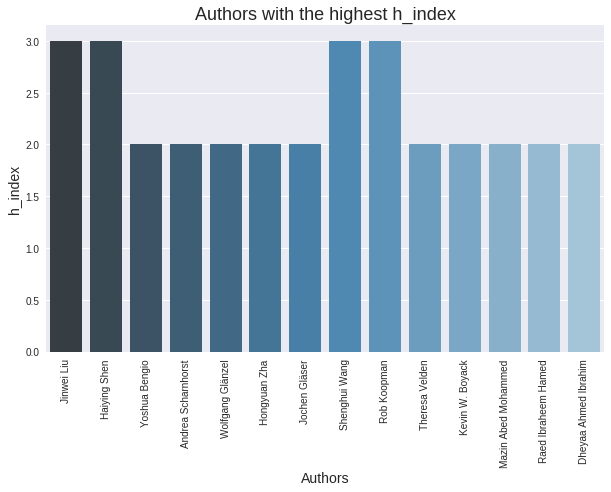

In [288]:
pl.figure(figsize=(10, 6))
sns.barplot(x='author', y='h_index', data=df_hindex[df_hindex['h_index'] > 1], palette="Blues_d")
pl.xlabel('Authors', fontsize=14)
pl.ylabel('h_index', fontsize=14)
pl.xticks(rotation=90)
pl.title('Authors with the highest h_index', fontsize=18)
pl.show()
pl.savefig('h_index of Authors.jpg')

** (ii) Comparing it with our metric (Task 3)**

In [289]:
# Finding the intersection from top 100 authors from both the metrics to find how far is our metric from the h-index
top100_from_hindex_rankings = collections.defaultdict(int)
rank = 1
for index, row in top100_hindex.iterrows():
    top100_from_hindex_rankings[row.author] = rank
    rank += 1
    
top100_from_our_metric_rankings = collections.defaultdict(int)
rank = 1
for index, row in top100.iterrows():
    top100_from_our_metric_rankings[row.author] = rank
    rank += 1
    
common_authors = set(top100_from_our_metric_rankings.keys()).intersection(set(top100_from_hindex_rankings.keys()))
print(len(common_authors))
print(common_authors)
print("")
for x in common_authors:
    print("author: " + x)
    print("ranking from hindex: " + str(top100_from_hindex_rankings[x]))
    print("ranking from our metric: " + str(top100_from_our_metric_rankings[x]))
    print("")

3
{'Johan Bergman', 'Eli Biham', 'Yi Zhang'}

author: Johan Bergman
ranking from hindex: 89
ranking from our metric: 81

author: Eli Biham
ranking from hindex: 82
ranking from our metric: 49

author: Yi Zhang
ranking from hindex: 46
ranking from our metric: 88



In [290]:
print("hindex rankings:")
print(top100_from_hindex_rankings)
print("\n\n")
print("our metric rankings:")
print(top100_from_our_metric_rankings)

hindex rankings:
defaultdict(<class 'int'>, {'Jinwei Liu': 1, 'Shenghui Wang': 2, 'Haiying Shen': 3, 'Rob Koopman': 4, 'Yoshua Bengio': 5, 'Theresa Velden': 6, 'Hongyuan Zha': 7, 'Jochen Gläser': 8, 'Andrea Scharnhorst': 9, 'Wolfgang Glänzel': 10, 'Mazin Abed Mohammed': 11, 'Kevin W. Boyack': 12, 'Raed Ibraheem Hamed': 13, 'Dheyaa Ahmed Ibrahim': 14, 'Steven Swanson': 15, 'Mohan M. Trivedi': 16, 'Conor Ryan': 17, 'Pierre-Étienne Meunier': 18, 'Yan Chen': 19, 'Nitesh V. Chawla': 20, 'Bart Rienties': 21, 'Sergey Levine': 22, 'Krzysztof Simiński': 23, 'Quan Nguyen': 24, 'Yilin Chen': 25, 'Katharina Spiel': 26, 'Tom Sercu': 27, 'Amy Voida': 28, 'Qiang Yang': 29, 'Fazhi He': 30, 'Melody Moh': 31, 'Bo Zhang': 32, 'Cordelia Schmid': 33, 'Pawel Misiorek': 34, 'Andrzej Szwabe': 35, 'Reynold Cheng': 36, 'Christoph Lange': 37, 'Richard Bowden': 38, 'Rui Li': 39, 'Qingming Huang': 40, 'Christos Faloutsos': 41, 'Yao Zhao': 42, 'Jack Brimberg': 43, 'Damien Woods': 44, 'Tao Li': 45, 'Yi Zhang': 46, '

In [291]:
print(top100_from_our_metric_rankings.keys())

dict_keys(['Bart Preneel', 'Wei Wang', 'Thomas Hess', 'Jie Zhang', 'Toshio Fukuda', 'Li Li', 'Hideto Ide', 'Yang Yang', 'Hui Li', 'Orr Dunkelman', 'Ming Zhang', 'Jun Wang', 'Fei Wang', 'Feiping Nie', 'Fan Zhang', 'Wei Chen', 'Yang Liu', 'Pierre Hansen', 'Vincent Rijmen', 'Florian Mendel', 'Hao Wang', 'Wei Li', 'Rui Zhang', 'Wen Gao', 'Hsinchun Chen', 'Peter Buneman', 'Wei Zhang', 'Jun Zhang', 'Peng Zhang', 'Jan Camenisch', 'Yu Zhang', 'Wei Liu', 'Kazuo Yamafuji', 'Christian Rechberger', 'Ivan Damgård', 'Lei Zhang', 'Bin Wang', 'Michitaka Kameyama', 'Nathan Keller', 'Gang Wang', 'Li Fei-Fei', 'Ying Zhang', 'Katsumi Tanaka', 'Yi Wang', 'Hui Zhang', 'Lei Wang', 'Ming Li', 'Jun Liu', 'Eli Biham', 'Qing Li', 'Andreas K. Maier', 'Xuelong Li', 'Rama Chellappa', 'Erik D. Demaine', 'Krzysztof R. Apt', 'Cristopher Moore', 'Mohamed-Slim Alouini', 'Peng Wang', 'Tok Wang Ling', 'Gang Li', 'Yan Li', 'Xiang Li', 'Jia Deng', 'Perambur S. Neelakanta', 'Sourav S. Bhowmick', 'Min Zhang', 'Jie Li', 'Timni

# STEP 8. Interesting Visualizations

In [0]:
# We tried to find some other interesting plots and visualizations and relations between the features of the dataset

** (i) Avg number of citations per number of authors**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



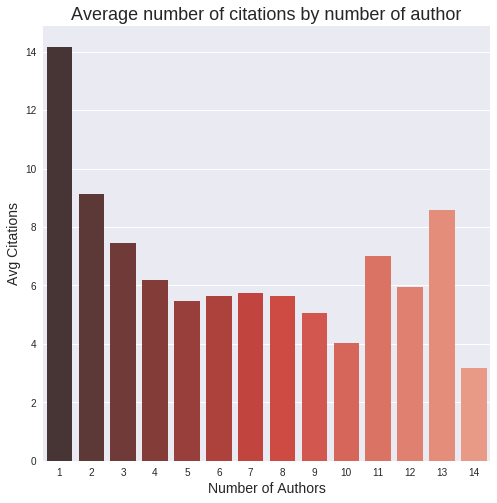

In [293]:
# how many citation per number of authors
total_authors = collections.defaultdict(list)
for index, row in data_df.iterrows():
    total_authors[len(row.authors)].append(row.n_citation)

# Avg number of citations per number of authors
avg_author = collections.defaultdict(list)
for key, val in total_authors.items():
#     print(key, val)
    avg_author[key] = sum(val) / float(len(val))

# list(avg_author.keys())

avg_author_citation = pd.DataFrame.from_dict({'NumOfAuthors': list(avg_author.keys()), 
                                  'AvgCitations': list(avg_author.values())})

# avg_author_citation.head(5)

pl.figure(figsize=(8, 8))
sns.barplot(x='NumOfAuthors', y='AvgCitations', data=avg_author_citation[avg_author_citation['NumOfAuthors'] < 15], palette="Reds_d")
pl.xlabel('Number of Authors', fontsize=14)
pl.ylabel('Avg Citations', fontsize=14)
# pl.xticks(rotation=90)
pl.title('Average number of citations by number of author', fontsize=18)
pl.show()
# pl.savefig('h_index of Authors.jpg')

# avg_author_citation[avg_author_citation['NumOfAuthors'] > 15]


** (ii) Number of papers in each category**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



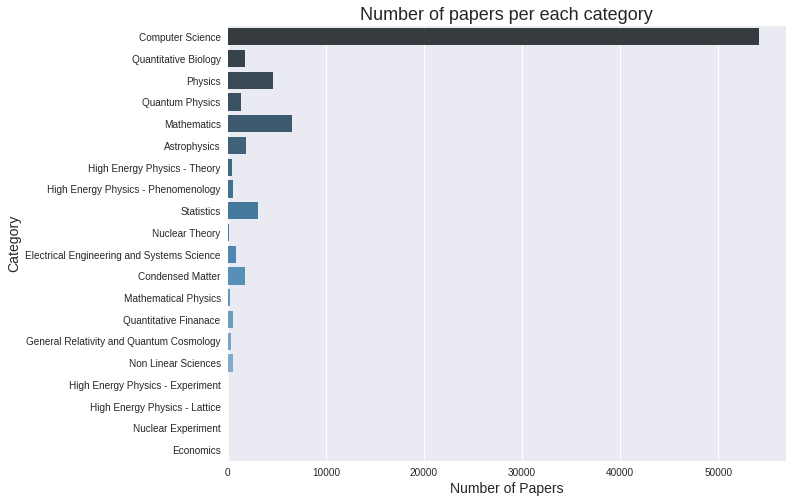

In [294]:
df_cat_paper = pd.DataFrame()
df_cat_paper['category'] = category_numberPaper.keys()
df_cat_paper['numberPaper'] = category_numberPaper.values()
pl.figure(figsize=(10, 8))
sns.barplot(x='numberPaper', y='category', data=df_cat_paper, palette="Blues_d")
pl.xlabel('Number of Papers', fontsize=14)
pl.ylabel('Category', fontsize=14)
pl.title('Number of papers per each category', fontsize=18)
pl.show()

** (iii) Number of papers in each sub-category**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



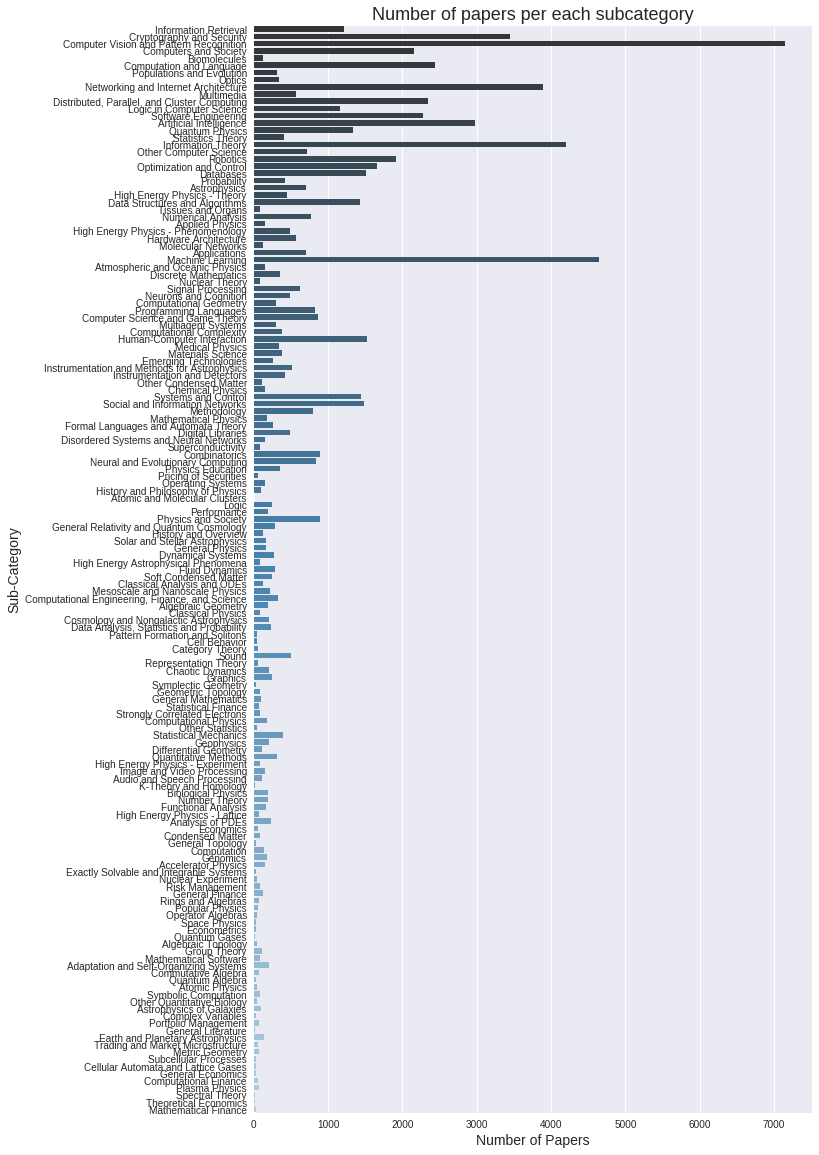

In [295]:
df_subcat_paper = pd.DataFrame()
df_subcat_paper['subcategory'] = subcategory_numberPaper.keys()
df_subcat_paper['numberPaper'] = subcategory_numberPaper.values()
pl.figure(figsize=(10, 20))
sns.barplot(x='numberPaper', y='subcategory', data=df_subcat_paper, palette="Blues_d")
pl.xlabel('Number of Papers', fontsize=14)
pl.ylabel('Sub-Category', fontsize=14)
pl.title('Number of papers per each subcategory', fontsize=18)
pl.show()

** (iv) Number of authors in each category**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



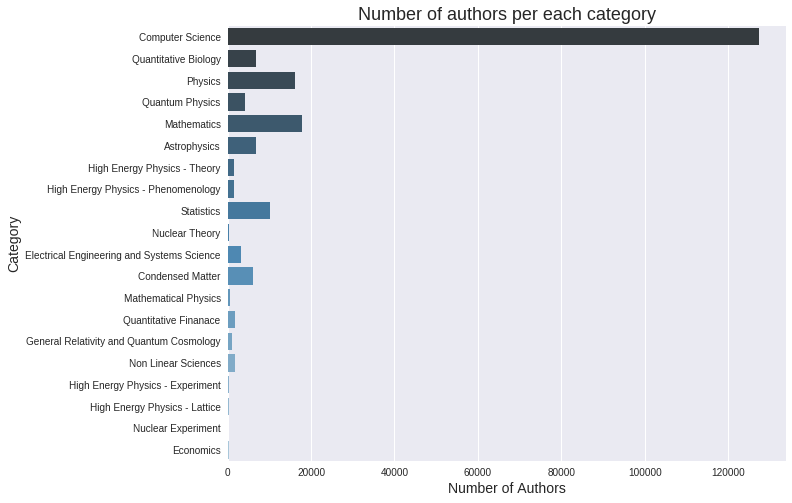

In [296]:
def num_of_authors(row):
    global category_numberAuthor
    return len(category_numberAuthor[row.category])

df_cat_author = pd.DataFrame()
df_cat_author['category'] = category_numberAuthor.keys()
df_cat_author['numberAuthors'] = df_cat_author.apply(num_of_authors, axis = 1)
pl.figure(figsize=(10, 8))
sns.barplot(x='numberAuthors', y='category', data=df_cat_author, palette="Blues_d")
pl.xlabel('Number of Authors', fontsize=14)
pl.ylabel('Category', fontsize=14)
pl.title('Number of authors per each category', fontsize=18)
pl.show()

** (v) Number of authors in each sub-category**

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



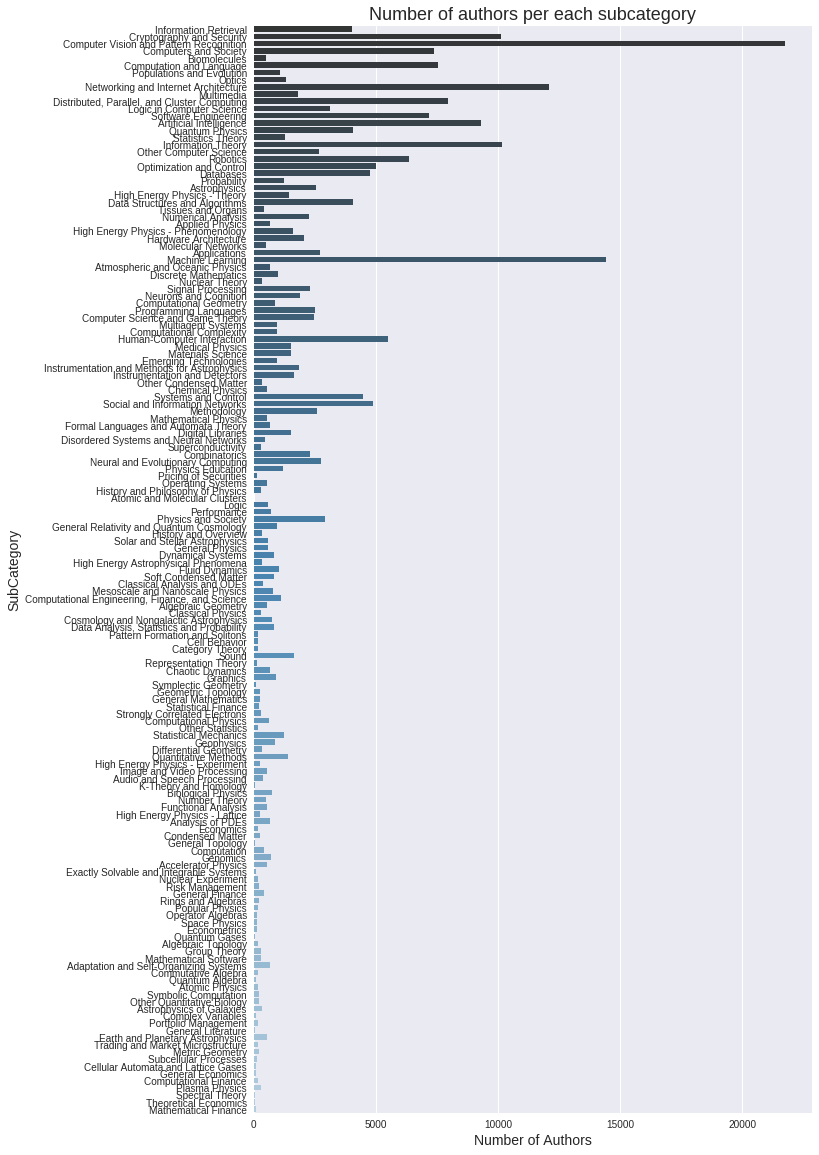

In [297]:
def num_of_authors(row):
    global subcategory_numberAuthor
    return len(subcategory_numberAuthor[row.subcategory])

df_subcat_author = pd.DataFrame()
df_subcat_author['subcategory'] = subcategory_numberAuthor.keys()
df_subcat_author['numberAuthors'] = df_subcat_author.apply(num_of_authors, axis = 1)
pl.figure(figsize=(10, 20))
sns.barplot(x='numberAuthors', y='subcategory', data=df_subcat_author, palette="Blues_d")
pl.xlabel('Number of Authors', fontsize=14)
pl.ylabel('SubCategory', fontsize=14)
pl.title('Number of authors per each subcategory', fontsize=18)
pl.show()

### **Ridge Regression**

In [0]:
rr = Ridge(alpha=0.01)

In [0]:
X = data_df[['cat_pop', 'subcat_pop', 'conference_score', 'year']]

In [0]:
y = data_df['paper_score']

In [318]:
rr.fit(X, y)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [319]:
data_df.iloc[0]

authors                  [Zheng Xu, Runbin Shi, Zhihao Sun, Yaqi Li, Yu...
id                                    001eef4f-1d00-4ae6-8b4f-7e66344bbc6e
n_citation                                                               0
references               [0a11984c-ab6e-4b75-9291-e1b700c98d52, 1f4152a...
title                    A Heterogeneous System for Real-Time Detection...
venue                        high performance computing and communications
year                                                                  2016
subcategory                                          Information Retrieval
category                                                  Computer Science
cat_pop                                                           0.221553
subcat_pop                                                       0.0332804
popularity                                                       0.0709349
authors_with_position    [(Zheng Xu, 1.0), (Runbin Shi, 0.9), (Zhihao S...
conference_score         

In [322]:
rr.predict([[0.221, 0.033, 2016, 0.019]])

array([0.72030415])

### **Neural network**

In [357]:
model = Sequential()
model.add(Dense(4, input_dim=4, kernel_initializer='normal', activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
history = model.fit(X, y, epochs=150, batch_size=50,  verbose=1, validation_split=0.2)

Train on 63087 samples, validate on 15772 samples
Epoch 1/150
63087/63087 [==============================] - 2s 38us/step - loss: 17.1266 - mean_squared_error: 17.1266 - mean_absolute_error: 0.6393 - val_loss: 1.0737e-04 - val_mean_squared_error: 1.0737e-04 - val_mean_absolute_error: 0.0049
Epoch 2/150
63087/63087 [==============================] - 2s 25us/step - loss: 1.6323e-04 - mean_squared_error: 1.6323e-04 - mean_absolute_error: 0.0041 - val_loss: 1.0215e-04 - val_mean_squared_error: 1.0215e-04 - val_mean_absolute_error: 0.0039
Epoch 3/150
63087/63087 [==============================] - 2s 25us/step - loss: 1.6151e-04 - mean_squared_error: 1.6151e-04 - mean_absolute_error: 0.0040 - val_loss: 9.7768e-05 - val_mean_squared_error: 9.7768e-05 - val_mean_absolute_error: 0.0033
Epoch 4/150
63087/63087 [==============================] - 2s 25us/step - loss: 1.6070e-04 - mean_squared_error: 1.6070e-04 - mean_absolute_error: 0.0039 - val_loss: 9.1728e-05 - val_mean_squared_error: 9.1728e-0

In [358]:
model.predict(np.array([[0.221, 0.033, 2016, 0.019]]))

array([[0.00641]], dtype=float32)

In [363]:
data_df['title'][0]

'A Heterogeneous System for Real-Time Detection with AdaBoost'

In [376]:
for i in sorted(conf_score.keys()):
  print(i)

A Quarterly Journal of Operations Research
ACM Communications in Computer Algebra
ACM Computing Surveys
ACM Crossroads Student Magazine
ACM Journal of Experimental Algorithms
ACM Journal on Computing and Cultural Heritage
ACM Journal on Emerging Technologies in Computing Systems
ACM Queue
ACM Sigarch Computer Architecture News
ACM Sigbed Review
ACM Sigcas Computers and Society
ACM Sigevolution
ACM Sigsam Bulletin
ACM Sigsim Simulation Digest
ACM Sigsmall\/pc Notes
ACM Sigsoft Software Engineering Notes
ACM Sigweb Newsletter
ACM Transactions in Embedded Computing Systems
ACM Transactions on Accessible Computing
ACM Transactions on Algorithms
ACM Transactions on Architecture and Code Optimization
ACM Transactions on Autonomous and Adaptive Systems
ACM Transactions on Computation Theory
ACM Transactions on Computational Logic
ACM Transactions on Computer Systems
ACM Transactions on Computer-Human Interaction
ACM Transactions on Cyber-Physical Systems
ACM Transactions on Database Systems
A

In [373]:
conf_score

defaultdict(float,
            {'high performance computing and communications': 0.01934979981207526,
             'international conference on conceptual structures': 0.04514953289484227,
             'international conference on control, automation, robotics and vision': 0.07524004281827434,
             'Communications of The ACM': 0.1267500737543618,
             'Journal of Computational Chemistry': 0.01934979981207524,
             'international conference on data mining': 0.07844176189315422,
             'Frontiers in Digital Humanities': 0.006449933270691753,
             'international symposium on information theory and its applications': 0.08384913251899268,
             'international conference on machine learning and applications': 0.038709198245994385,
             'Lecture Notes in Computer Science': 0.28920300891980744,
             'international symposium on mixed and augmented reality': 0.05893401675490063,
             'others': 0.3485772186656,
             'too

In [0]:
testing_df = pd.DataFrame(columns=['cat_pop', 'subcat_pop', 'conference_score', 'year'])

In [395]:
X.head()

cat_pop  subcat_pop  conference_score  year
0  0.221553    0.033280           0.01935  2016
1  0.221553    0.066312           0.04515  2016
2  0.221553    0.051033           0.07524  2016
3  0.234329    0.032731           0.12675  2017
4  0.109077    0.057133           0.01935  2017

The Rate of Convergence of AdaBoost

In [0]:
testing_df.loc[0] = [,2,3,4]

In [397]:
testing_df

cat_pop subcat_pop conference_score year
0       1          2                3    4

In [404]:
data_df['title'][10]

'Modeling Physical Structure as Additional Constraints for Stereoscopic Optical See-Through Head-Mounted Display Calibration'